# Multilayer Perceptrons


# Setup

In [ ]:
%autosave 60
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.config import list_physical_devices
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
# from sklearn.metrics import accuracy_score
# np.random.seed(42)

Autosaving every 60 seconds


In [ ]:
if not list_physical_devices("GPU"):
    warning = """No GPU was detected. DNNs can be very slow without a GPU.\n
    Go to Runtime > Change runtime type and select a GPU hardware accelerator."""
    # raise Exception(warning)
else:
    print("T4 GPU detected")

 # Task 1: Data Preprocessing

## 1.1 Importing the Dataset

Importing the training and testing data into dataframes

In [ ]:
np.random.seed(0)
train_url = 'https://raw.githubusercontent.com/Aryanchaturvedi075/Sign_Language_MNIST/main/sign_mnist_train.csv'
test_url = 'https://raw.githubusercontent.com/Aryanchaturvedi075/Sign_Language_MNIST/main/sign_mnist_test.csv'
train_df, test_df = pd.read_csv(train_url), pd.read_csv(test_url)

## 1.2 Normalising Data



1. Extracting the labels of training and testing data
2. Converting pd.dataframes to numpy arrays
3. Normalising data
4. Performing Mean Subtraction


In [ ]:
# For Training Data
train_label = train_df['label']
train_input = train_df.drop(['label'],axis=1)

# For Testing Data
test_label = test_df['label']
test_input = test_df.drop(['label'],axis=1)

# Convert Pandas Dataframe to Numpy of type float + Normalise Data
train_input = train_input.values.astype(np.float64) / 255
test_input = test_input.values.astype(np.float64) / 255

# Perform Mean Subtraction
train_input -= np.mean(train_input, axis = 0)
test_input -= np.mean(test_input, axis = 0)

print(train_input.shape)
print(test_input.shape)

(27455, 784)
(7172, 784)


## 1.3 Validation Data

Splitting both training and testing data to obtain the validation data
Training, Validation and Testing Split Ratio [0.7, 0.15, 0.15]


In [ ]:
# Obtaining validation data randomly splitting the training and testing data
X_train, X_valid, Y_train, Y_valid = train_test_split(
    train_input,
    train_label,
    test_size=0.117,
    train_size=0.883
)
X_test, X_test_subset, Y_test, Y_test_subset = train_test_split(
    test_input,
    test_label,
    test_size=0.276,
    train_size=0.724
)
# X_test, Y_test = test_input, test_label

# Rejoin the data from training and testing pool and re-shuffle
X_valid = np.concatenate((X_valid, X_test_subset))
Y_valid = np.concatenate((Y_valid, Y_test_subset))

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(24242, 784)
(5193, 784)
(5192, 784)


## 1.4 One Hot Encoding



In [ ]:
lb=LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_valid = lb.fit_transform(Y_valid)
Y_test = lb.fit_transform(Y_test)

## 1.5 Previewing Processed Data

Text(0.5, 1.0, 'label: 13  letter: M')

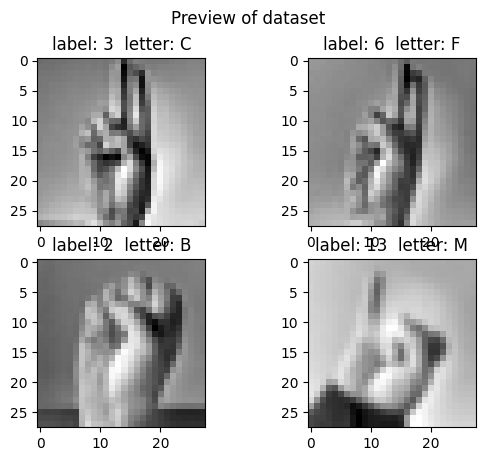

In [ ]:
# Previewing how the dataset looks
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

fig,axe=plt.subplots(2,2)
fig.suptitle('Preview of dataset')
axe[0,0].imshow(X_train[0].reshape(28,28),cmap='gray')
axe[0,0].set_title('label: 3  letter: C')
axe[0,1].imshow(X_train[1].reshape(28,28),cmap='gray')
axe[0,1].set_title('label: 6  letter: F')
axe[1,0].imshow(X_train[2].reshape(28,28),cmap='gray')
axe[1,0].set_title('label: 2  letter: B')
axe[1,1].imshow(X_train[4].reshape(28,28),cmap='gray')
axe[1,1].set_title('label: 13  letter: M')

# Task 2: Implementing the MLP

### Previous Implementations

Version 1

In [ ]:
# #implementing MLP
# logistic = lambda z: 1./ (1 + np.exp(-z))
# relu = lambda x: np.maximum(0,x)

# class MLP:
#     def __init__(self,function,num_hidden, num_units,loss_fn,learning_rate = 0.1):
#         self.function = function
#         self.num_hidden = num_hidden
#         self.num_units = num_units
#         self.loss_fn = loss_fn
#         self.learning_rate = learning_rate
#         #initialize weights
#         self.weights = np.random.randn(num_units) * 0.01
#         #intialize biases
#         self.biases = np.zeros(num_hidden)

#     def fit(self, x, y, optimizer, epochs = 150):
#         N,D = x.shape
#         def gradient(x, y, params):
#             v, w = params
#             z = self.function(np.dot(x, v)) #N x M
#             yh = self.function(np.dot(z, w))#N
#             dy = yh - y #N
#             dw = np.dot(z.T, dy)/N #M
#             dz = np.outer(dy, w) #N x M
#             dv = np.dot(x.T, dz * z * (1 - z))/N #D x M
#             dparams = [dv, dw]
#             return dparams
#         w = np.random.randn(self.M) * .01
#         v = np.random.randn(D,self.M) * .01
#         params0 = [v,w]
#         self.params = optimizer.run(gradient, x, y, params0)
#         return self

#     def predict(self, x):
#         v, w = self.params
#         z = self.function(np.dot(x, v))
#         yh = self.function(np.dot(z, w))
#         return yh

#     def evaluate_accuracy(self,y,yh):
#         correct_predictions = np.sum(y == yh)
#         total_samples = len(y)
#         accuracy = correct_predictions / total_samples
#         return accuracy


# class GradientDescent:
#     def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
#         self.learning_rate = learning_rate
#         self.max_iters = max_iters
#         self.epsilon = epsilon

#     def run(self, gradient_fn, x, y, params):
#         norms = np.array([np.inf])
#         t = 1
#         while np.any(norms > self.epsilon) and t < self.max_iters:
#             grad = gradient_fn(x, y, params)
#             for p in range(len(params)):
#                 params[p] -= self.learning_rate * grad[p]
#             t += 1
#             norms = np.array([np.linalg.norm(g) for g in grad])
#         return params

Version 2

In [ ]:
# #define a generic layer type
# class NeuralNetLayer:
#     def __init__(self):
#         self.gradient = None
#         self.parameters = None

#     def forward(self, x):
#         raise NotImplementedError

#     def backward(self, gradient):
#         raise NotImplementedError

# class LinearLayer(NeuralNetLayer):
#     def __init__(self, input_size, output_size):
#         super().__init__()
#         self.ni = input_size
#         self.no = output_size
#         self.w = np.random.randn(output_size, input_size)
#         self.b = np.random.randn(output_size)
#         self.cur_input = None
#         self.parameters = [self.w, self.b]

#     def forward(self, x):
#         print("forward in lin")
#         self.cur_input = x
#         # print(self.w.shape, "w")
#         # print(x.shape, "x")
#         print("forward in lin")
#         print("return", (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b)
#         print("NaN in x:", np.isnan(x).any())
#         print("NaN in weights:", np.isnan(self.w).any())
#         print("NaN in biases:", np.isnan(self.b).any())
#         return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

#     def backward(self, gradient):
#         assert self.cur_input is not None, "Must call forward before backward"
#         #dw = gradient.dot(self.cur_input)
#         dw = gradient[:, :, None] @ self.cur_input[:, None, :]
#         db = gradient
#         self.gradient = [dw, db]
#         return gradient.dot(self.w)


# class ReLULayer(NeuralNetLayer):
#     def __init__(self):
#         super().__init__()

#     def forward(self, x):
#         print("forward in relu")
#         self.gradient = np.where(x > 0, 1.0, 0.0)
#         return np.maximum(0, x)

#     def backward(self, gradient):
#         assert self.gradient is not None, "Must call forward before backward"
#         return gradient * self.gradient



# class SoftmaxOutputLayer(NeuralNetLayer):
#     print("forward in soft")
#     def __init__(self):
#         super().__init__()
#         self.cur_probs = None

#     def forward(self, x):
#         exps = np.exp(x)
#         probs = exps / np.sum(exps, axis=-1)[:, None]
#         probs = np.clip(probs, None, 1000000)
#         self.cur_probs = probs
#         return probs

#     def backward(self, target):
#         assert self.cur_probs is not None, "Must call forward before backward"
#         return self.cur_probs - target


# #wrong init
# class MLP:
#     def __init__(self, activation_func, nuc:\Users\chatu\Desktop\Sign_Language_MNIST\MLP.pym_hidden_layers, units_per_layer, num_features):
#         if(num_hidden_layers != len(units_per_layer)):
#             raise ValueError("number of hidden layers does not match the length of length of unit list");
#         self.layers = []
#         self.layers.append(LinearLayer(num_features, units_per_layer[0]));
#         for layer in range(num_hidden_layers-1):
#           self.layers.append(activation_func())
#           self.layers.append(LinearLayer(units_per_layer[layer],units_per_layer[layer+1]))
#         self.layers.append(activation_func())
#         self.layers.append(LinearLayer(units_per_layer[-1],24))
#         self.layers.append(SoftmaxOutputLayer())

#     def forward(self, x):
#         for layer in self.layers:
#             x = layer.forward(x)
#         return x

#     def backward(self, target):
#         for layer in self.layers[::-1]:
#             target = layer.backward(target)

#     def train(self, optimizer, data_x, data_y, steps):
#         losses = []
#         # labels = np.eye(3)[np.array(data_y)]
#         counter = 0
#         for _ in tqdm(range(steps)):
#             predictions = self.forward(data_x)
#             loss = -(data_y * np.log(predictions)).sum(axis=-1).mean()
#             losses.append(loss)
#             self.backward(data_y)
#             optimizer.step()
#             counter =counter +1
#         plt.plot(losses)
#         plt.xlabel("Epoch")
#         plt.ylabel("Cross entropy loss")

#     def predict(self, x):
#         probabilities = self.forward(x)
#         return np.argmax(probabilities, axis=-1)


# class Optimizer:
#     def __init__(self, net: MLP):
#         self.net = net

#     def step(self):
#         for layer in self.net.layers[::-1]:
#             if layer.parameters is not None:
#                 self.update(layer.parameters, layer.gradient)

#     def update(self, params, gradient):
#         raise NotImplementedError


# class GradientDescentOptimizer(Optimizer):
#     def __init__(self, net: MLP, lr: float):
#         super().__init__(net)
#         self.lr = lr


#     def update(self, params, gradient):
#         for (p, g) in zip(params, gradient):
#             p -= self.lr * g.mean(axis=0)

#     def check_grad(self, X, y):
#         N, C = y.shape
#         D = X.shape[1]
#         diff = np.zeros((D, C))
#         W = self.W.copy()
#         for i in range(D):
#             for j in range(C):
#                 epsilon = np.zeros((D, C))
#                 epsilon[i, j] = np.random.rand() * 1e-4
#                 self.W = self.W + epsilon
#                 J1 = self.ce(X, y)
#                 self.W = W
#                 self.W = self.W - epsilon
#                 J2 = self.ce(X, y)
#                 self.W = W
#                 numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
#                 derived_grad = self.grad(X, y)[i, j]
#                 diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
#                             np.square(derived_grad + numeric_grad).sum()
#         return diff.sum()

Version 3

In [ ]:
# acc = []
# width = ["32/32", "64/32", "64/64", "128/32", "128/64", "128/128" , "256/32" , "256/64" , "256/128" , "256/256"]
# width=[32,64,128,256]
# for l1 in width:
#   for l2 in width:

#     mlp = MLP(
#         sigmoid,
#         2,
#         [l1, l2],
#         X_train.shape[-1],
#       )
#     opt = GradientDescentOptimizer(mlp, LEARNING_RATE)
#     mlp.train(opt, X_train, Y_train, X_valid, Y_valid, steps=20)
#     yh = mlp.predict(X_test)
#     accuracy = evaluate_acc(Y_test, yh)
#     acc.append(accuracy*100)

#     mlp2 = MLP(
#         ReLULayer,
#         2,
#         [128, 128],
#         X_train.shape[-1],
#     )
#     opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE)
#     mlp2.train(opt2, X_train, Y_train, X_valid, Y_valid, steps=20)
#     yh = mlp2.predict(X_test)
#     accuracy = evaluate_acc(Y_test, yh)
#     acc.append(accuracy*100)


#     mlp3 = MLP(
#         LeakyReLU,
#         2,
#         [128, 128],
#         X_train.shape[-1],
#     )


#   opt3 = GradientDescentOptimizer(mlp3, LEARNING_RATE)
#   mlp3.train(opt3, X_train, Y_train, X_valid, Y_valid, steps=20)
#   yh = mlp3.predict(X_test)
#   accuracy = evaluate_acc(Y_test, yh)
#   acc.append(accuracy*100)


# x = ["32/32", "64/32", "64/64", "128/32", "128/64", "128/128" , "256/32" , "256/64" , "256/128" , "256/256"]
# y1 = acc[1]
# y2 = acc[2]
# y3 = acc[0]

# # Create a figure
# plt.figure(figsize=(8, 6))
# # Plot multiple lines
# plt.plot(x, y1, label='relu', marker='o')
# plt.plot(x, y2, label='Leakyrelu', marker='o')
# plt.plot(x, y3, label='sigmoid', marker='o')
# # Adding titles and labels
# plt.title('Sigmoid vs relu vs leakyRelu')
# plt.xlabel('width')
# plt.ylabel('Accuracy')
# # Display the legend
# plt.legend()
# # Show the plot
# plt.show()

## 2.1 Neural Network Layers

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.w = np.random.randn(output_size, input_size) * np.sqrt(2. / input_size) # HE Initialization
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        dw = np.dot(gradient.T, self.cur_input)
        db = gradient.mean(axis=0)
        self.gradient = [dw, db]
        return gradient.dot(self.w)

In [ ]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class LeakyReLU(NeuralNetLayer):
    def __init__(self,epsilon=0.001):
        super().__init__()
        self.epsilon= epsilon

    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, self.epsilon)
        return np.where(x > 0, x, self.epsilon * x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class sigmoid(NeuralNetLayer):
    def __init__(self ):
        super().__init__()

    def forward(self, x):
        sigmoid = 1/(1 + np.exp(-x))
        self.gradient =sigmoid * (1 - sigmoid)
        return sigmoid

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        max_val = np.max(x, axis=1)[:, None]
        exps = np.exp(x - max_val)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

## 2.2 MLP

In [ ]:
class MLP:
    def __init__(self, activation_func, num_hidden_layers, units_per_layer, num_features, epsilon=0.01):
        if(num_hidden_layers != len(units_per_layer)):
            raise ValueError("number of hidden layers does not match the length of length of unit list");
        units_per_layer.append(24)
        self.layers = []
        self.layers.append(LinearLayer(num_features, units_per_layer[0]))
        for layer in range(num_hidden_layers):
            param = activation_func(epsilon) if activation_func == "LeakyReLU" else activation_func()
            self.layers.append(LinearLayer(units_per_layer[layer],units_per_layer[layer+1]))
        self.layers.append(SoftmaxOutputLayer())

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def predict(self, x):
        probabilities = self.forward(x)
        return np.argmax(probabilities, axis=-1)

    def train(self, optimizer, data_x, data_y, val_x, val_y, steps=35, batch_size=128, verbose=False, print_image=False):
        EPSILON = 1e-7
        losses = []
        num_batches = data_x.shape[0] // batch_size
        for epoch in tqdm(range(steps)):

            # Shuffling testing and validation data after each epoch to prevent overfitting
            data_x, data_y = shuffle(data_x, data_y, random_state=0)
            val_x, val_y = shuffle(val_x, val_y, random_state=0)
            if verbose:
              print("Epoch ", epoch, "/", steps)
            for i in range(num_batches):
                start = i * batch_size
                end = start + batch_size
                # Splitting data in batches and training the model sequentially
                x_batch = data_x[start:end]
                y_batch = data_y[start:end]
                predictions = self.forward(x_batch)
                loss = -(y_batch * np.log(predictions + EPSILON)).sum(axis=-1).mean()
                self.backward(y_batch)
                optimizer.step()

            # Running on Validation Data
            valid_pred = self.forward(val_x)
            valid_acc = evaluate_acc(val_y, np.argmax(valid_pred, axis=-1))
            valid_loss = -(val_y * np.log(valid_pred + EPSILON)).sum(axis=-1).mean()
            losses.append(valid_loss)
            self.backward(val_y)
            optimizer.step()

            if verbose:
                train_acc = evaluate_acc(data_y, self.predict(data_x))
                print("\nloss: {:0.3f}".format(valid_loss),
                      "\taccuracy: {:0.3f}".format(train_acc),
                      "\tvalidation accuracy: {:0.3f}".format(valid_acc)
                      )
        if print_image:
            plt.plot(losses)
            plt.xlabel("Epoch")
            plt.ylabel("Cross entropy loss")
            plt.show()

## 2.3 Gradient Descent

In [ ]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

In [ ]:
class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            np.clip(g, -10, 10, out=g)
            p -= self.lr * g

In [ ]:
class Gradient_l2_regularization(GradientDescentOptimizer):
  def __init__(self, net: MLP, lr: float, lambda_v: float):
        super().__init__(net, lr)
        self.lambda_v = lambda_v

def update(self, params, gradient):
    for i in range(len(params)):
        params[i] -= self.lr * (gradient[i] + self.lambda_v * params[i])

## 2.4 Multiclass Logistic Regression

In [ ]:
# no hidden layer MLP : multiclass regression
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)
        self.losses_train = []
        self.losses_valid = []

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
      y_pred = self.predict(X)
      epsilon = 1e-10
      y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
      return -np.sum(y * np.log(y_pred))


    def predict(self, X):
      scores = np.matmul(X, self.W)
      scores -= np.max(scores, axis=1, keepdims=True)
      exp_scores = np.exp(scores)
      y_pred = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
      return y_pred


    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.01, niter=100, tol=1e-4, patience=5, print_image=False):
        best_loss = np.inf
        patience_counter = patience
        for i in tqdm(range(niter)):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            self.losses_train.append(loss_train)
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                self.losses_valid.append(loss_valid)
                if loss_valid < best_loss:
                    best_loss = loss_valid
                    patience_counter = patience  # reset patience
                else:
                    patience_counter -= 1
                if patience_counter == 0:
                    print(f"Stopping early at iteration {i} due to increasing validation loss.")
                    break
            if i > 0 and np.abs(self.losses_train[i] - self.losses_train[i-1]) < tol:
                print(f"Convergence reached at iteration {i}.")
                break
        if print_image:
            plt.plot(self.losses_train)
            plt.xlabel("Epoch")
            plt.ylabel("Cross entropy loss")
            plt.show()

## 2.5 Visual and Evaluation Function

In [ ]:
def evaluate_acc(y_encoded , y_pred):
    y_true = np.argmax(y_encoded, axis=1)
    total_correct_predictions = np.sum(y_true == y_pred)
    overall_accuracy = total_correct_predictions / len(y_true)
    return overall_accuracy

In [ ]:
# For Plotting the Decision Boundary on training Data
def plot_decision_boundary(mlp: MLP, data_x, data_y):
    x0v = np.linspace(np.min(data_x[:,0]), np.max(data_x[:,0]), 200)
    x1v = np.linspace(np.min(data_x[:,1]), np.max(data_x[:,1]), 200)
    x0,x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T
    yh_all = np.argmax(mlp.forward(x_all), axis=-1)
    plt.scatter(data_x[:,0], data_x[:,1], c=data_y, marker='o', alpha=1)
    plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
    plt.ylabel('sepal length')
    plt.xlabel('sepal width')
    plt.title('decision boundary of the MLP')
    plt.show()

# Task 3: Experimentation

## Prelude for Section 3.5: Testing Hyperparameters

In [ ]:
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, X_train.shape[0]]

### Learning Rate

On Multiclass Regression Model

In [ ]:
accuracies = []
for lr in learning_rates:
    mlr_model = Multinomial_logistic(nFeatures=784, nClasses=len(np.unique(train_label))) # 28 24 X_train.shape[1]
    mlr_model.fit(X_train, Y_train, lr=lr, niter=50)
    y_pred_mlr = mlr_model.predict(X_test)
    y_pred_mlr_class = np.argmax(y_pred_mlr, axis=1) #get label
    accuracy = evaluate_acc(Y_test, y_pred_mlr_class)
    accuracies.append(accuracy*100)

 10%|█         | 5/50 [00:02<00:21,  2.11it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
# Convert learning rates to string labels for better x-axis labeling in the bar plot
learning_rate_labels = [str(lr) for lr in learning_rates]
plt.bar(learning_rate_labels, accuracies, color='skyblue', alpha=0.7)
plt.title('Learning Rate for Multiclass Regression (No Hidden Layers)')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Add the accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()
acc1 = np.array(accuracies)

On Single Layer MLP

In [ ]:
accuracies = []
for lr in learning_rates:
    mlp = MLP(
        ReLULayer,
        1, [32],
        X_train.shape[-1]
    )
    opt = GradientDescentOptimizer(mlp, lr)
    mlp.train(opt, X_train, Y_train, X_valid, Y_valid, steps=10)
    y_pred = mlp.predict(X_test)
    accuracy = evaluate_acc(Y_test, y_pred)
    accuracies.append(accuracy*100)

In [ ]:
plt.figure(figsize=(10, 6))
# Convert learning rates to string labels for better x-axis labeling in the bar plot
learning_rate_labels = [str(lr) for lr in learning_rates]
plt.bar(learning_rate_labels, accuracies, color='skyblue', alpha=0.7)
plt.title('Learning Rate on 1 Layer MLP')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Add the accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()

acc2 = np.array(accuracies)

On Double Layer MLP

In [ ]:
accuracies = []
for lr in learning_rates:
    mlp = MLP(
        ReLULayer,
        2, [64, 64],
        X_train.shape[-1]
    )
    opt = GradientDescentOptimizer(mlp, lr)
    mlp.train(opt, X_train, Y_train, X_valid, Y_valid, steps=20)
    y_pred = mlp.predict(X_test)
    accuracy = evaluate_acc(Y_test, y_pred)
    accuracies.append(accuracy*100)

In [ ]:
plt.figure(figsize=(10, 6))
# Convert learning rates to string labels for better x-axis labeling in the bar plot
learning_rate_labels = [str(lr) for lr in learning_rates]
plt.bar(learning_rate_labels, accuracies, color='skyblue', alpha=0.7)
plt.title('Learning Rate on 2 Layer MLP')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Add the accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()
acc3 = np.array(accuracies)

Computing Best Learning Rate

In [ ]:
index = np.argmax(acc1 + acc2 + acc3)
print("Learning Rate with Highest Accuracy:", learning_rates[index])

In [ ]:
LEARNING_RATE = 1e-3

### Batch Size

On Single Layer MLP

In [ ]:
accuracies = []
for b_size in batch_sizes:
    mlp = MLP(
        ReLULayer,
        1, [64],
        X_train.shape[-1]
    )
    opt = GradientDescentOptimizer(mlp, LEARNING_RATE)
    mlp.train(opt, X_train, Y_train, X_valid, Y_valid, steps=10, batch_size=b_size)
    y_pred = mlp.predict(X_test)
    accuracy = evaluate_acc(Y_test, y_pred)
    accuracies.append(accuracy*100)

In [ ]:
plt.figure(figsize=(10, 6))
batch_size_labels = [str(b) for b in batch_sizes]
plt.bar(batch_size_labels, accuracies, color='skyblue', alpha=0.7)
plt.title('Batch Size vs Accuracy (1 Layer MLP)')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Add the accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()
acc1 = np.array(accuracies)

On Double Layer MLP

In [ ]:
accuracies = []
for b_size in batch_sizes:
    mlp = MLP(
        ReLULayer,
        2, [64, 64],
        X_train.shape[-1]
    )
    opt = GradientDescentOptimizer(mlp, LEARNING_RATE)
    mlp.train(opt, X_train, Y_train, X_valid, Y_valid, steps=15, batch_size=b_size)
    y_pred = mlp.predict(X_test)
    accuracy = evaluate_acc(Y_test, y_pred)
    accuracies.append(accuracy*100)

In [ ]:
plt.figure(figsize=(10, 6))
batch_size_labels = [str(b) for b in batch_sizes]
plt.bar(batch_size_labels, accuracies, color='skyblue', alpha=0.7)
plt.title('Batch Size vs Accuracy (2 Layer MLP)')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', linewidth=0.7)
# Add the accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()
acc2 = np.array(accuracies)

Computing Optimal Batch Size

In [ ]:
index = np.argmax(acc1 + acc2)
print("Batch Size with Highest Accuracy:", batch_sizes[index])

## 3.1 MLP Models

In [ ]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

### 3.1.1 Running Multiclass Regression

100%|██████████| 200/200 [00:57<00:00,  3.47it/s]


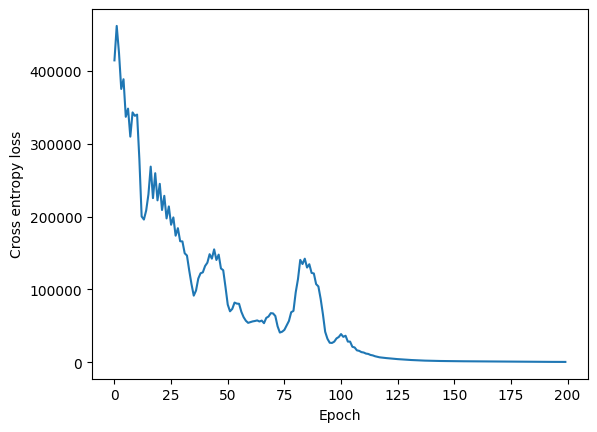

Overall Accuracy of MultiClass Regression Model 64.77272727272727


In [ ]:
# no hidden layer MLP : multiclass regression
mlr_model = Multinomial_logistic(nFeatures=784, nClasses=len(np.unique(train_label))) # 28 24 X_train.shape[1]
mlr_model.fit(X_train, Y_train, niter=200, print_image=True)
y_pred_mlr = mlr_model.predict(X_test)
y_pred_mlr_class = np.argmax(y_pred_mlr, axis=1) #get label
accuracy_mlr = evaluate_acc(Y_test, y_pred_mlr_class)
print("Overall Accuracy of MultiClass Regression Model", accuracy_mlr * 100)

### 3.1.2 Running Neural Network

100%|██████████| 35/35 [00:29<00:00,  1.21it/s]


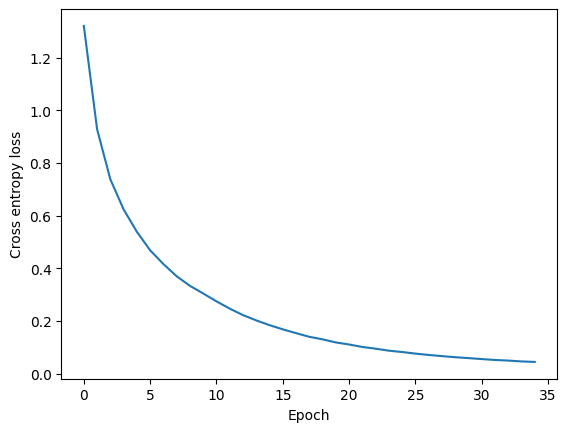

Overall Accuracy of Single Layer MLP 98.95993836671802


In [ ]:
# One Hidden Layer
mlp = MLP(
    ReLULayer,
    1, [64],
    X_train.shape[-1]
)

opt = GradientDescentOptimizer(mlp, LEARNING_RATE)
mlp.train(opt, X_train, Y_train, X_valid, Y_valid, print_image=True)
y_pred = mlp.predict(X_test)
accuracy_mlp1 = evaluate_acc(Y_test, y_pred)
print("Overall Accuracy of Single Layer MLP", accuracy_mlp1 * 100)

# print("Decision Boundary of 1 Layer MLP")
# plot_decision_boundary(mlp, X_train, Y_train)

100%|██████████| 35/35 [00:34<00:00,  1.01it/s]


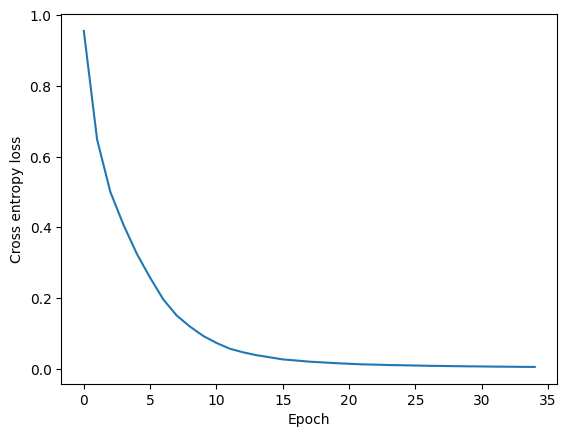

Overall Accuracy of Double Layer MLP 99.884437596302


In [ ]:
# Two Hidden Layers
mlp = MLP(
    ReLULayer,
    2, [64, 64],
    X_train.shape[-1]
)

opt = GradientDescentOptimizer(mlp, LEARNING_RATE)
mlp.train(opt, X_train, Y_train, X_valid, Y_valid, print_image=True)
y_pred = mlp.predict(X_test)
accuracy_mlp2 = evaluate_acc(Y_test, y_pred)
print("Overall Accuracy of Double Layer MLP", accuracy_mlp2 * 100)

# print("Decision Boundary of 2 Layer MLP")
# plot_decision_boundary(mlp, X_train, Y_train)

### 3.1.3 Optimal Number of Hidden Units

In [ ]:
units = [32,64,128,256]

On Single Layer MLP

In [ ]:
acc=[]
for l1 in units:
    mlp = MLP(
        ReLULayer,
        1,[l1],
        X_train.shape[-1]
    )
    opt = GradientDescentOptimizer(mlp, LEARNING_RATE)
    mlp.train(opt, X_train, Y_train, X_valid, Y_valid, steps=20)
    y_pred = mlp.predict(X_test)
    accuracy = evaluate_acc(Y_test, y_pred)
    acc.append(accuracy*100)
    print("First Layer units:", l1,
          "\taccuracy: ",accuracy*100)

100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


First Layer units: 32 	accuracy:  92.75808936825885


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


First Layer units: 64 	accuracy:  92.39214175654854


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


First Layer units: 128 	accuracy:  91.66024653312789


100%|██████████| 20/20 [01:05<00:00,  3.26s/it]


First Layer units: 256 	accuracy:  89.29121725731896


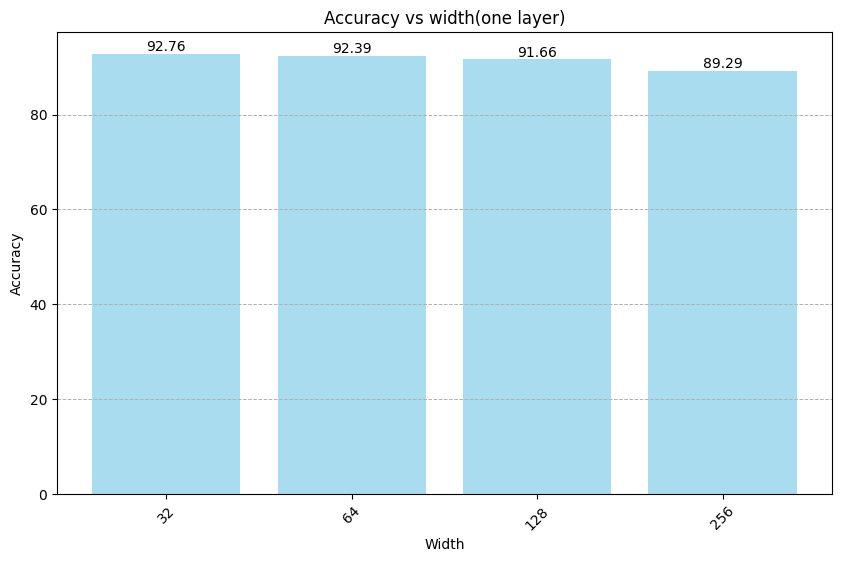

In [ ]:
plt.figure(figsize=(10, 6))
units_labels = [str(unit) for unit in units]
plt.bar(units_labels, acc, color='skyblue', alpha=0.7)
plt.title('Accuracy vs width(one layer)')
plt.xlabel('Width')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', linewidth=0.7)
# Add the accuracy values on top of the bars
for i, acc in enumerate(acc):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()

On Double Layer MLP

In [ ]:
acc=[]
for i in range(len(units)):
    for j in range(i+1):
        mlp = MLP(
            ReLULayer,
            2,[units[i],units[j]],
            X_train.shape[-1]
        )
        opt = GradientDescentOptimizer(mlp, LEARNING_RATE)
        mlp.train(opt, X_train, Y_train, X_valid, Y_valid, steps=20)
        y_pred = mlp.predict(X_test)
        accuracy = evaluate_acc(Y_test, y_pred)
        acc.append(accuracy*100)
        print("First Layer units:",units[i],
              "\tSecond Layer units:", units[j],
              "\taccuracy: ",accuracy*100)

100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


First Layer units: 32 	Second Layer units: 32 	accuracy:  95.64714946070877


100%|██████████| 20/20 [00:17<00:00,  1.15it/s]


First Layer units: 64 	Second Layer units: 32 	accuracy:  94.93451463790447


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


First Layer units: 64 	Second Layer units: 64 	accuracy:  97.49614791987673


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


First Layer units: 128 	Second Layer units: 32 	accuracy:  91.10169491525424


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


First Layer units: 128 	Second Layer units: 64 	accuracy:  94.10631741140215


100%|██████████| 20/20 [00:27<00:00,  1.35s/it]


First Layer units: 128 	Second Layer units: 128 	accuracy:  95.49306625577813


100%|██████████| 20/20 [01:05<00:00,  3.30s/it]


First Layer units: 256 	Second Layer units: 32 	accuracy:  82.2226502311248


100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


First Layer units: 256 	Second Layer units: 64 	accuracy:  83.9175654853621


100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


First Layer units: 256 	Second Layer units: 128 	accuracy:  85.74730354391372


100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


First Layer units: 256 	Second Layer units: 256 	accuracy:  89.81124807395993


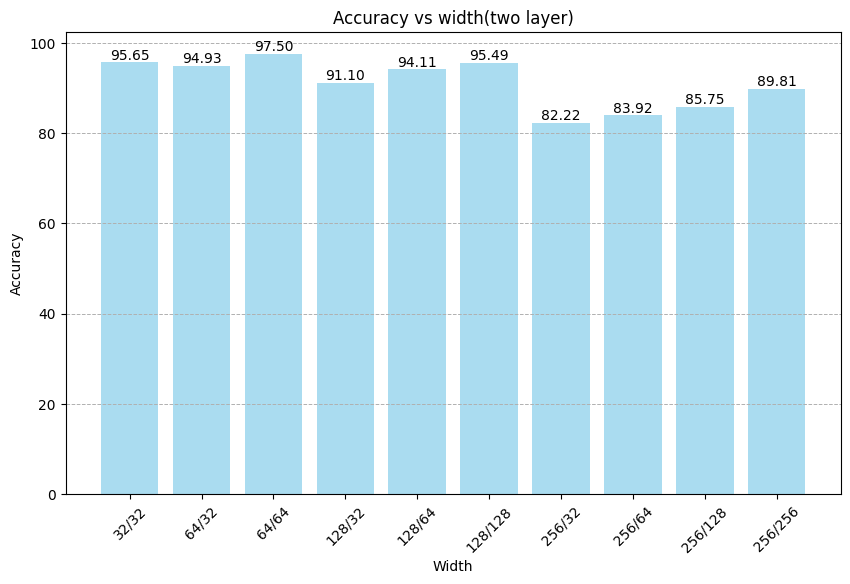

In [ ]:
width = ["32/32", "64/32", "64/64", "128/32", "128/64", "128/128" , "256/32" , "256/64" , "256/128" , "256/256"]
plt.figure(figsize=(10, 6))
plt.bar(width, acc, color='skyblue', alpha=0.7)
plt.xlabel('Width')
plt.ylabel('Accuracy')
plt.title('Accuracy vs width(two layer)')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', linewidth=0.7)
for i, acc in enumerate(acc):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()

## 3.2 : Sigmoid and Leaky-ReLU

In [ ]:
width = ["32/32" ,"64/32", "64/64", "128/32", "128/64", "128/128"  , "256/32" , "256/64" , "256/128" , "256/256"]
widths=[32, 64,128,256]

acc_relu=[]
acc_Leakyrelu=[]
acc_sigmoid=[]

for l1 in widths:
    for l2 in widths:
        if(l1 >= l2):
            print(l1)
            print(l2)
            mlp1 = MLP(
                sigmoid,
                2,
                [l1,l2],
                X_train.shape[-1],
              )
            opt1 = GradientDescentOptimizer(mlp1,  LEARNING_RATE)
            mlp1.train(opt1, X_train, Y_train, X_valid, Y_valid, steps=20)
            yh = mlp1.predict(X_test)
            accuracy = evaluate_acc(Y_test, yh)
            acc_sigmoid.append(accuracy*100)


            mlp2 = MLP(
                ReLULayer,
                2,
                [l1,l2],
                X_train.shape[-1],
              )
            opt2 = GradientDescentOptimizer(mlp2,  LEARNING_RATE)
            mlp2.train(opt2, X_train, Y_train, X_valid, Y_valid, steps=20)
            yh = mlp2.predict(X_test)
            accuracy = evaluate_acc(Y_test, yh)
            acc_relu.append(accuracy*100)


            mlp3 = MLP(
                LeakyReLU,
                2,
                [l1,l2],
                X_train.shape[-1],

              )
            opt3 = GradientDescentOptimizer(mlp3, LEARNING_RATE)
            mlp3.train(opt3, X_train, Y_train, X_valid, Y_valid, steps=20)
            yh = mlp3.predict(X_test)
            accuracy = evaluate_acc(Y_test, yh)
            acc_Leakyrelu.append(accuracy*100)

32
32


100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


64
32


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


64
64


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


128
32


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


128
64


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


128
128


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


256
32


100%|██████████| 20/20 [01:05<00:00,  3.27s/it]


256
64


100%|██████████| 20/20 [01:07<00:00,  3.36s/it]


256
128


100%|██████████| 20/20 [01:11<00:00,  3.55s/it]


256
256


100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


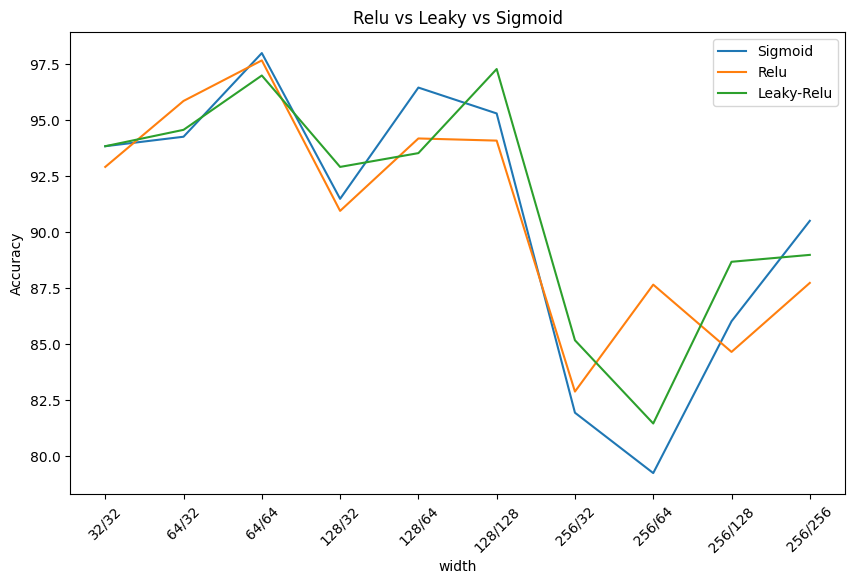

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(width, acc_sigmoid, label='Sigmoid')  # Add a label for the legend
plt.plot(width, acc_relu, label='Relu')
plt.plot(width, acc_Leakyrelu, label='Leaky-Relu')

plt.title('Relu vs Leaky vs Sigmoid')
plt.xlabel('width')
plt.ylabel('Accuracy')

plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
## 3.2 : Sigmoid and Leaky-ReLU

width = ["32", "64", "128","256"]
widths=[32, 64, 128, 256]
acc_relu=[]
acc_Leakyrelu=[]
acc_sigmoid=[]

for l1 in widths:
    mlp1 = MLP(
        sigmoid,
        1,
        [l1],
        X_train.shape[-1],
      )
    opt1 = GradientDescentOptimizer(mlp1, LEARNING_RATE)
    mlp1.train(opt1, X_train, Y_train, X_valid, Y_valid, steps=20)
    yh = mlp1.predict(X_test)
    accuracy = evaluate_acc(Y_test, yh)
    acc_sigmoid.append(accuracy*100)


    mlp2 = MLP(
        ReLULayer,
        1,
        [l1],
        X_train.shape[-1],
      )
    opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE)
    mlp2.train(opt2, X_train, Y_train, X_valid, Y_valid, steps=20)
    yh = mlp2.predict(X_test)
    accuracy = evaluate_acc(Y_test, yh)
    acc_relu.append(accuracy*100)


    mlp3 = MLP(
        LeakyReLU,
        1,
        [l1],
        X_train.shape[-1],
      )
    opt3 = GradientDescentOptimizer(mlp3, LEARNING_RATE)
    mlp3.train(opt3, X_train, Y_train, X_valid, Y_valid, steps=20)
    yh = mlp3.predict(X_test)
    accuracy = evaluate_acc(Y_test, yh)
    acc_Leakyrelu.append(accuracy*100)

100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


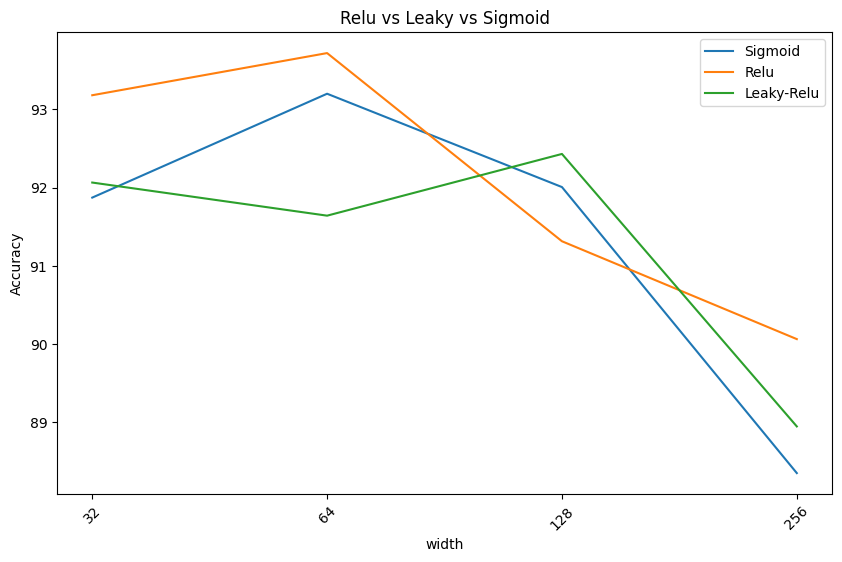

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(width, acc_sigmoid, label='Sigmoid')  # Add a label for the legend
plt.plot(width, acc_relu, label='Relu')
plt.plot(width, acc_Leakyrelu, label='Leaky-Relu')

plt.title('Relu vs Leaky vs Sigmoid')
plt.xlabel('width')
plt.ylabel('Accuracy')

plt.xticks(rotation=45)
plt.legend()
plt.show()

## 3.3 Regularization

In [ ]:
lambda_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]

In [ ]:
accuracies = []
for lv in lambda_values:
    mlp2 = MLP(
        ReLULayer,
        2,
        [64,64],
        X_train.shape[-1])

    opt_reg = Gradient_l2_regularization(mlp2, LEARNING_RATE, lv)
    mlp2.train(opt_reg, X_train, Y_train , X_valid, Y_valid, steps=20)
    yh = mlp2.predict(X_test)
    accuracy = evaluate_acc(Y_test, yh)
    accuracies.append(accuracy*100)

100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


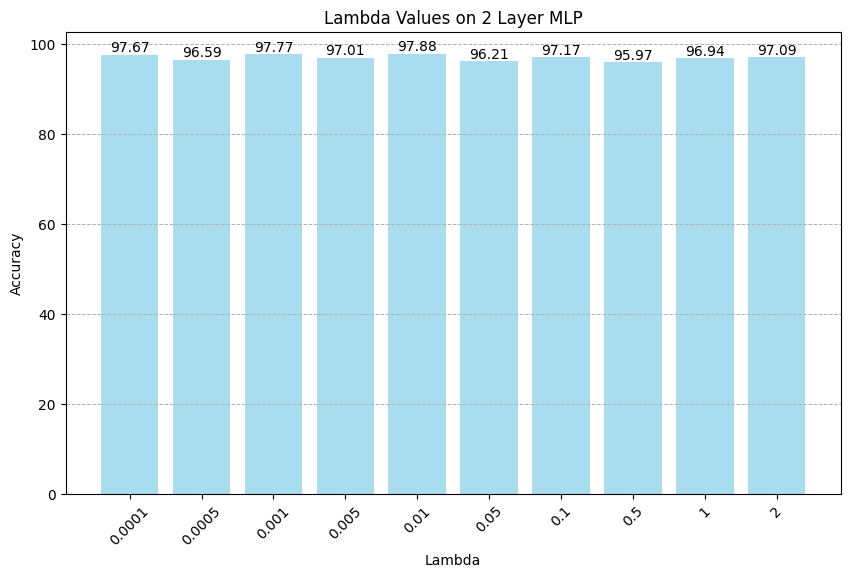

In [ ]:
plt.figure(figsize=(10, 6))
# Convert learning rates to string labels for better x-axis labeling in the bar plot
lambda_labels = [str(lv) for lv in lambda_values]
plt.bar(lambda_labels, accuracies, color='skyblue', alpha=0.7)
plt.title('Lambda Values on 2 Layer MLP')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()

## 3.4 Convolutional Neural Network

In [ ]:
units = [32,64,128,256]
learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256, 512, 1024, 4096, X_train.shape[0]]

In [ ]:
# Necessary for the Convolutional Neural Network
X_train_rsp = X_train.reshape(-1,28,28,1)
X_valid_rsp = X_valid.reshape(-1,28,28,1)
X_test_rsp = X_test.reshape(-1,28,28,1)

### 3.4.1 Optimal Learning Rate for CNN

In [ ]:
accuracies = []
for lr in learning_rates:
        conv_model=Sequential()
        conv_model.add(Conv2D(128,kernel_size=(5,5), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
        conv_model.add(MaxPool2D(pool_size=(3,3), strides=2,padding='same'))
        conv_model.add(Conv2D(64,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
        conv_model.add(MaxPool2D((2,2),2,padding='same'))
        conv_model.add(Conv2D(32,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
        conv_model.add(MaxPool2D((2,2),2,padding='same'))
        conv_model.add(Flatten())
        conv_model.add(Dense(units=128,activation='relu'))
        conv_model.add(Dense(units=128,activation='relu'))
        conv_model.add(Dense(units=24,activation='softmax'))
        # conv_model.summary()

        conv_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate = lr),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )
        conv_model.fit(
            X_train_rsp, Y_train,
            batch_size = 128,
            epochs = 15,
            verbose=0,
            validation_data=(X_valid_rsp, Y_valid)
        )
        _, test_acc = conv_model.evaluate(X_test_rsp, Y_test)
        accuracies.append(test_acc*100)

163/163 [==============================] - 1s 4ms/step - loss: 3.2105 - accuracy: 0.0352


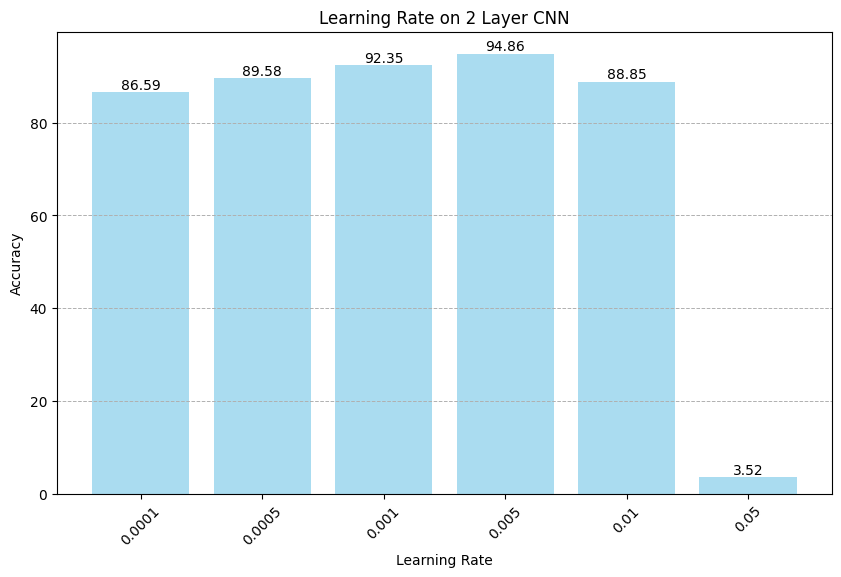

In [ ]:
plt.figure(figsize=(10, 6))
# Convert learning rates to string labels for better x-axis labeling in the bar plot
learning_rate_labels = [str(lr) for lr in learning_rates]
plt.bar(learning_rate_labels, accuracies, color='skyblue', alpha=0.7)
plt.title('Learning Rate on 2 Layer CNN')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()

### 3.4.2 Optimal Batch Size for CNN

In [ ]:
accuracies = []
for b_size in batch_sizes:
        conv_model=Sequential()
        conv_model.add(Conv2D(128,kernel_size=(5,5), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
        conv_model.add(MaxPool2D(pool_size=(3,3), strides=2,padding='same'))
        conv_model.add(Conv2D(64,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
        conv_model.add(MaxPool2D((2,2),2,padding='same'))
        conv_model.add(Conv2D(32,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
        conv_model.add(MaxPool2D((2,2),2,padding='same'))
        conv_model.add(Flatten())
        conv_model.add(Dense(units=128,activation='relu'))
        conv_model.add(Dense(units=128,activation='relu'))
        conv_model.add(Dense(units=24,activation='softmax'))
        # conv_model.summary()

        conv_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate = LEARNING_RATE),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )
        conv_model.fit(
            X_train_rsp, Y_train,
            batch_size = b_size,
            epochs = 15,
            verbose=0,
            validation_data=(X_valid_rsp, Y_valid)
        )
        _, test_acc = conv_model.evaluate(X_test_rsp, Y_test)
        accuracies.append(test_acc*100)

163/163 [==============================] - 1s 3ms/step - loss: 0.6906 - accuracy: 0.7675


ResourceExhaustedError: Graph execution error:

Detected at node sequential_14/conv2d_43/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-34-c1d61545f10d>", line 21, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

OOM when allocating tensor with shape[24242,64,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_14/conv2d_43/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_232471]

In [ ]:
plt.figure(figsize=(10, 6))
batch_size_labels = [str(b) for b in batch_sizes]
plt.bar(batch_size_labels, accuracies, color='skyblue', alpha=0.7)
plt.title('Batch Size on 2 Layer CNN')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Add the accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()

### 3.4.3 Optimal Strides for CNN

In [ ]:
#testing different strides
strides = [1,2,3]
accuracies = []
for stride1 in strides:
  for stride2 in strides:
        conv_model=Sequential()
        conv_model.add(Conv2D(128,kernel_size=(5,5), strides=stride1,padding='same',activation='relu',input_shape=(28,28,1)))
        conv_model.add(MaxPool2D(pool_size=(3,3), strides=stride2,padding='same'))
        conv_model.add(Conv2D(64,kernel_size=(2,2), strides=stride1,activation='relu',padding='same'))
        conv_model.add(MaxPool2D((2,2),2,padding='same'))
        conv_model.add(Conv2D(32,kernel_size=(2,2), strides=stride1,activation='relu',padding='same'))
        conv_model.add(MaxPool2D((2,2),2,padding='same'))
        conv_model.add(Flatten())
        conv_model.add(Dense(units=128,activation='relu'))
        conv_model.add(Dense(units=32,activation='relu'))
        conv_model.add(Dense(units=24,activation='softmax'))
        # conv_model.summary()

        conv_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),   # Ideal Learning Rate
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )
        conv_model.fit(
            X_train_rsp, Y_train,
            batch_size = 128,
            epochs = 20,
            verbose=0,
            validation_data=(X_valid_rsp, Y_valid)
        )
        _, test_acc = conv_model.evaluate(X_test_rsp, Y_test)
        accuracies.append(test_acc*100)

163/163 [==============================] - 0s 2ms/step - loss: 1.9936 - accuracy: 0.6745


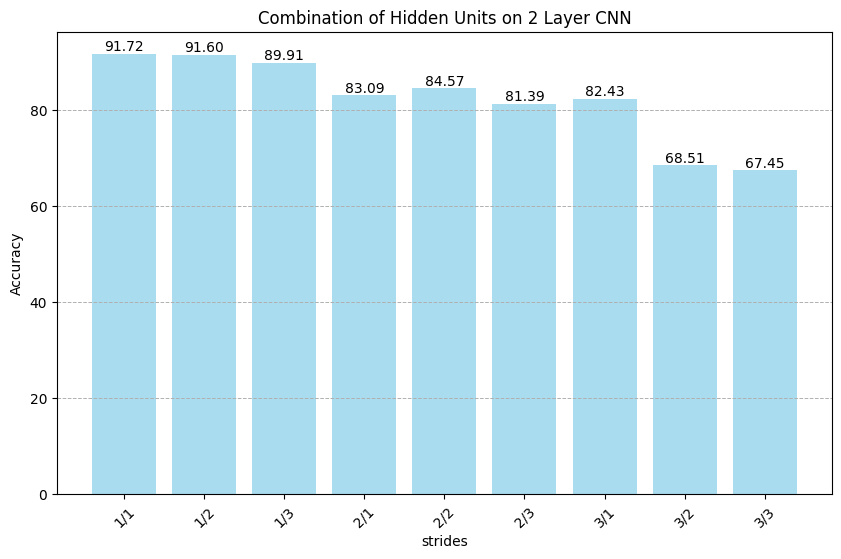

In [ ]:
strides = ["1/1","1/2","1/3","2/1","2/2","2/3","3/1","3/2","3/3"]
plt.figure(figsize=(10, 6))
plt.bar(strides, accuracies, color='skyblue', alpha=0.7)
plt.title('Combination of Hidden Units on 2 Layer CNN')
plt.xlabel('strides')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', linewidth=0.7)
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()

### 3.4.4 Optimal Combination of Hidden Layers for CNN

In [ ]:
accuracies = []
for i in range(len(units)):
    for j in range(i+1):
        conv_model=Sequential()
        conv_model.add(Conv2D(128,kernel_size=(5,5), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
        conv_model.add(MaxPool2D(pool_size=(3,3), strides=2,padding='same'))
        conv_model.add(Conv2D(64,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
        conv_model.add(MaxPool2D((2,2),2,padding='same'))
        conv_model.add(Conv2D(32,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
        conv_model.add(MaxPool2D((2,2),2,padding='same'))
        conv_model.add(Flatten())
        conv_model.add(Dense(units=units[i],activation='relu'))
        conv_model.add(Dense(units=units[j],activation='relu'))
        conv_model.add(Dense(units=24,activation='softmax'))
        # conv_model.summary()

        conv_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),   # Ideal Learning Rate
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )
        conv_model.fit(
            X_train_rsp, Y_train,
            batch_size = 128,
            epochs = 20,
            verbose=0,
            validation_data=(X_valid_rsp, Y_valid)
        )
        _, test_acc = conv_model.evaluate(X_test_rsp, Y_test)
        accuracies.append(test_acc*100)
        print("First Layer units:",units[i],
              "\tSecond Layer units:", units[j],
              "\taccuracy: ",test_acc*100)

163/163 [==============================] - 0s 3ms/step - loss: 0.5656 - accuracy: 0.9041
First Layer units: 32 	Second Layer units: 32 	accuracy:  90.40831923484802
163/163 [==============================] - 1s 3ms/step - loss: 0.4177 - accuracy: 0.9349
First Layer units: 64 	Second Layer units: 32 	accuracy:  93.48998665809631
163/163 [==============================] - 1s 4ms/step - loss: 0.5662 - accuracy: 0.9172
First Layer units: 64 	Second Layer units: 64 	accuracy:  91.71802997589111
163/163 [==============================] - 1s 4ms/step - loss: 0.6445 - accuracy: 0.9153
First Layer units: 128 	Second Layer units: 32 	accuracy:  91.52542352676392
163/163 [==============================] - 1s 3ms/step - loss: 0.5116 - accuracy: 0.9282
First Layer units: 128 	Second Layer units: 64 	accuracy:  92.8158700466156
163/163 [==============================] - 0s 3ms/step - loss: 0.5177 - accuracy: 0.9124
First Layer units: 128 	Second Layer units: 128 	accuracy:  91.2365198135376
163/163 

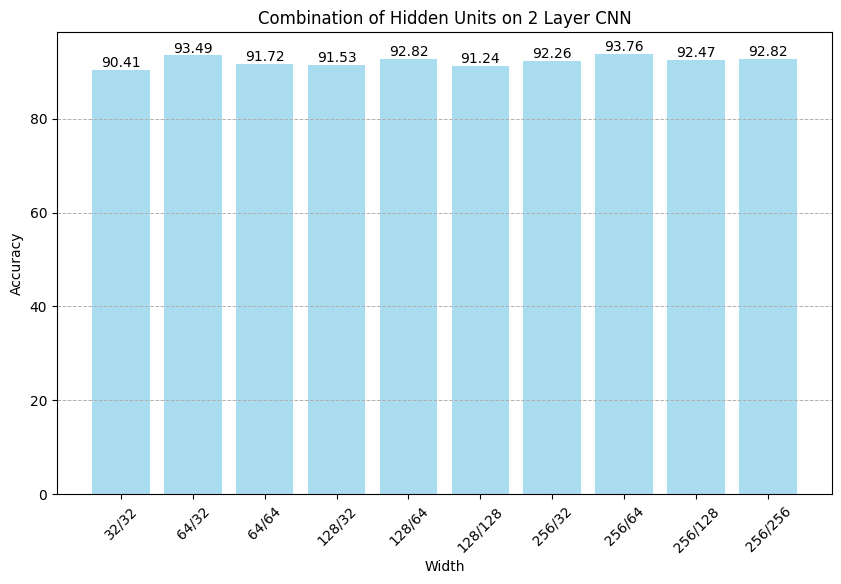

In [ ]:
width = ["32/32", "64/32", "64/64", "128/32", "128/64", "128/128" , "256/32" , "256/64" , "256/128" , "256/256"]
plt.figure(figsize=(10, 6))
plt.bar(width, accuracies, color='skyblue', alpha=0.7)
plt.title('Combination of Hidden Units on 2 Layer CNN')
plt.xlabel('Width')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', linewidth=0.7)
for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()

## 3.5 MLP Architecture

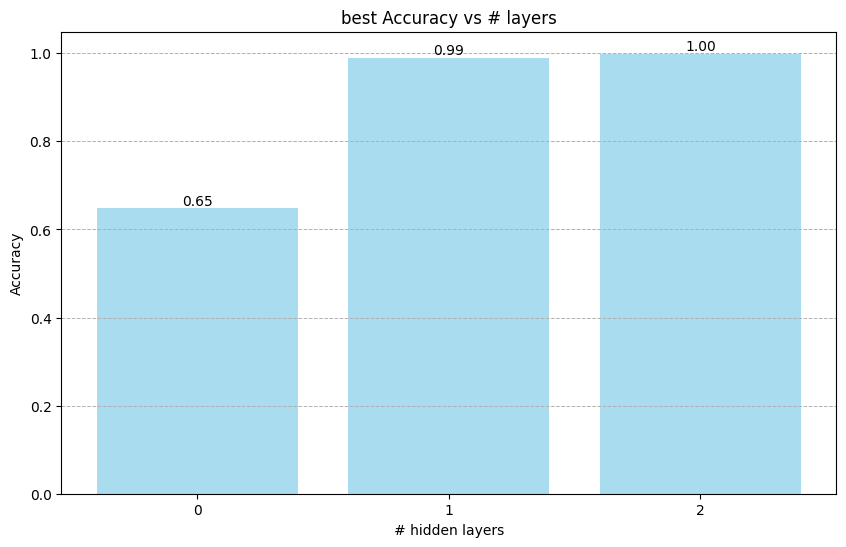

In [ ]:
width = ["0", "1", "2"]
acc=[accuracy_mlr, accuracy_mlp1, accuracy_mlp2]

plt.figure(figsize=(10, 6))
plt.bar(width, acc, color='skyblue', alpha=0.7)
plt.xlabel('# hidden layers')
plt.ylabel('Accuracy')
plt.title('best Accuracy vs # layers')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
for i, acc in enumerate(acc):
    plt.text(i, acc, f"{acc:.2f}", ha = 'center', va = 'bottom')
plt.show()

Highest Performing MLP Implementation:
Learning Rate = 0.001 and
2 Hidden Layers, with 128 and 128 hidden units, run on 100 epochs with an accuracy of

100%|██████████| 50/50 [01:17<00:00,  1.54s/it]


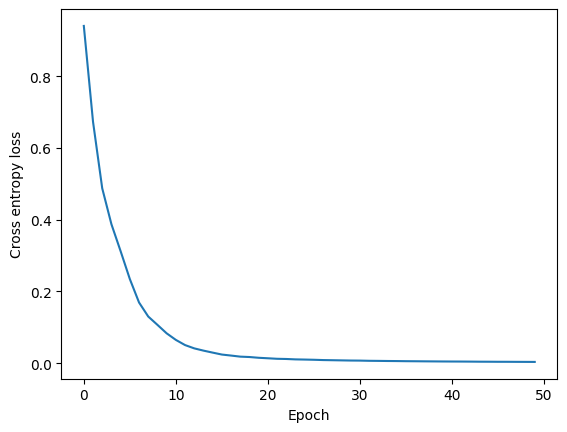

Overall Accuracy of Double Layer MLP 99.884437596302


In [ ]:
# Two Hidden Layers
optimal_mlp = MLP(
    ReLULayer,
    2, [128, 128],
    X_train.shape[-1]
)

opt = Gradient_l2_regularization(optimal_mlp, LEARNING_RATE, 0.01)
optimal_mlp.train(opt, X_train, Y_train, X_valid, Y_valid, steps=50, print_image=True)
y_pred = mlp.predict(X_test)
accuracy = evaluate_acc(Y_test, y_pred)
print("Overall Accuracy of Double Layer MLP", accuracy * 100)

In [ ]:
conv_model=Sequential()
conv_model.add(Conv2D(128,kernel_size=(5,5), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
conv_model.add(MaxPool2D(pool_size=(3,3), strides=2,padding='same'))
conv_model.add(Conv2D(64,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
conv_model.add(MaxPool2D((2,2),2,padding='same'))
conv_model.add(Conv2D(32,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
conv_model.add(MaxPool2D((2,2),2,padding='same'))
conv_model.add(Flatten())
conv_model.add(Dense(units=256,activation='relu'))
conv_model.add(Dense(units=256,activation='relu'))
conv_model.add(Dense(units=24,activation='softmax'))
# conv_model.summary()

conv_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),   # Ideal Learning Rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
conv_model.fit(
    X_train_rsp, Y_train,
    batch_size = 128,
    epochs = 50,
    verbose=0,
    validation_data=(X_valid_rsp, Y_valid)
)
_, test_acc = conv_model.evaluate(X_test_rsp, Y_test)

163/163 [==============================] - 0s 3ms/step - loss: 0.5904 - accuracy: 0.9324


In [ ]:
width = ["32/32" ,"64/32", "64/64", "128/32", "128/64", "128/128"  , "256/32" , "256/64" , "256/128" , "256/256"]
widths=[32,64,128,256]

acc_mlp=[]
acc_convNN=[]

for l1 in widths:
    for l2 in widths:
        if(l1 >= l2):
            optimal_mlp = MLP(
                ReLULayer,
                2,
                [l1,l2],
                X_train.shape[-1],
            )
            opt_reg = Gradient_l2_regularization(optimal_mlp,  LEARNING_RATE, 0.01)
            optimal_mlp.train(opt_reg, X_train, Y_train, X_valid, Y_valid, steps=20)
            yh = optimal_mlp.predict(X_test)
            accuracy = evaluate_acc(Y_test, yh)
            acc_mlp.append(accuracy*100)

            conv_model=Sequential()
            conv_model.add(Conv2D(128,kernel_size=(5,5), strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
            conv_model.add(MaxPool2D(pool_size=(3,3), strides=2,padding='same'))
            conv_model.add(Conv2D(64,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
            conv_model.add(MaxPool2D((2,2),2,padding='same'))
            conv_model.add(Conv2D(32,kernel_size=(2,2), strides=1,activation='relu',padding='same'))
            conv_model.add(MaxPool2D((2,2),2,padding='same'))
            conv_model.add(Flatten())
            conv_model.add(Dense(units=256,activation='relu'))
            conv_model.add(Dense(units=256,activation='relu'))
            conv_model.add(Dense(units=24,activation='softmax'))
            # conv_model.summary()
            conv_model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),   # Ideal Learning Rate
                loss="categorical_crossentropy",
                metrics=["accuracy"]
            )
            conv_model.fit(
                X_train_rsp, Y_train,
                batch_size = 128,
                epochs = 20,
                verbose=0,
                validation_data=(X_valid_rsp, Y_valid)
            )
            _, test_acc = conv_model.evaluate(X_test_rsp, Y_test)
            acc_convNN.append(test_acc)

100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


163/163 [==============================] - 4s 26ms/step - loss: 0.4352 - accuracy: 0.9247


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


163/163 [==============================] - 4s 24ms/step - loss: 0.3532 - accuracy: 0.9401


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


163/163 [==============================] - 3s 21ms/step - loss: 0.5036 - accuracy: 0.9305


100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(width, acc_mlp, label='MLP')  # Add a label for the legend
plt.plot(width, acc_convNN, label='CNN')

plt.title('Optimised MLP vs Convolutional Neural Network')
plt.xlabel('width')
plt.ylabel('Accuracy')

plt.xticks(rotation=45)
plt.legend()
plt.show()

NameError: name 'plt' is not defined